# Chemical Structure Alignment

Molecular alignment is a fundamental problem in cheminformatics and can be used for  structure  determination,  similarity  based  searching,  and ligand-baseddrug design *et al*. This problem can be solved as a orthogonal Procrustes problem when given two matrices representing three-dimensional coordinates.  The code block below shows the ease-of-use of the `Procrustes` library for protein structure alignment, one of themost fundamental problems in structural biophysics.

Here, we are going to use `procrustes.rotational` for protein structure alignment as an example, which is one of the fundamental problems in structural biology and structured-based drug design. A well-known structure alignment method is the *Kabsch* algorithm, which involves three steps: 
1. translation of the structures to have a common centroid;
2. computation of the coordinate covariance matrix;
3. finding the optimal rotation matrix. 

This is simply a rotational Procrustes problem.

Here, we used *IOData* library to load the Protein Data Bank (PDB)
file format containing the X-ray crystal structure of the human deoxyhemoglobin (PDB ID: 2HHB). This selection
of this protein was inspired by the [BiomolecularStructures library](https://biomolecularstructures.readthedocs.io/en/latest/kabsch/) which contains the well-known Kabsch algorithm for structure alignment. This algorithm is the same as rotational Procrustes, which allows one to compare the accuracy and efficiency of our implementation to those of existing libraries. 

The structure of 2HHB has 
cyclic-$C_2$  global symmetry, where chain A and chain C (chain B and chain D) are hemoglobin deoxy-alpha (beta) chains 
as denoted in **Fig. (i)**. Thus the rotational Procrustes can 
be used to align the $C_{\alpha}$ atoms in chain A and C of the protein to show that they are homologous. 
The root-mean-square deviation (RMSD) is traditionally used to assess the discrepancy between structures 
before and after the translation-rotation transformation with 39.5 Å (**Fig. (ii)**) and 0.23 Å (**Fig. (iii)**) respectively.

![Fig. 1. protein structure alignment with rotational Procrustes.](notebook_data/chemical_strcuture_alignment/protein_alignment.png "Fig. 1. protein structure alignment with rotational Procrustes.")

In [ ]:
# install matplotlib
!pip install matplotlib

# install iodata
!pip install git+https://github.com/theochem/iodata.git@master

We will load $C_{\alpha}$ atom coordinates with `iodata` (https://github.com/theochem/iodata).

In [1]:
import numpy as np
    
from iodata import load_one
from iodata.utils import angstrom
from procrustes import rotational

# load PDB
pdb = load_one("notebook_data/chemical_strcuture_alignment/2hhb.pdb")

# get coordinates of C_alpha atoms in chains A & C (in angstrom)
chainid = pdb.extra['chainids']
attypes = pdb.atffparams['attypes']
# alpha carbon atom coordinates in chain A
ca_a = pdb.atcoords[(chainid == 'A') & (attypes == 'CA')] / angstrom
# alpha carbon atom coordinates in chain A
ca_c = pdb.atcoords[(chainid == 'C') & (attypes == 'CA')] / angstrom

Root-mean-square deviation (RMSD) is a used to assess the 
discrepancy between structures, and was calculated before and after superposition translation and rotation operations were performed by rotational orthogonal Procrustes. The RMSD values before alignment is calculated as 39.47 Å, reaffirming that chain A and chain C are far
away from each other. 

In [2]:
rmsd_before = np.sqrt(np.mean(np.sum((ca_a - ca_c)**2, axis=1)))
print("RMSD of initial coordinates:", rmsd_before)

RMSD of initial coordinates: 39.46851987559469


In [3]:
# define a function to plot the coordinates

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_atom_coordinates(coords1, coords2,
                          figsize=(12, 10),
                          fontsize_label=14,
                          fontsize_title=16,
                          fontsize_legend=16,
                          label1=None,
                          label2=None,
                          title=None,
                          figfile=None):
    """Plot Cartesian coordinates of given atoms.

    Parameters
    ----------
    coords1: np.ndarray
        Cartesian coordinates of given atom set 1.
    coords2: np.ndarray
        Cartesian coordinates of given atom set 2.
    figsize : (float, float), optional
        Figure size with width and height in inchies.
    fontsize_label: int, optional
        The font size for labels. Default=14.
    fontsize_label: int, optional
        The font size for title. Default=16.
    label1 : str, optional
        Label for coords1. Default=None.
    label2 : str, optional
        Label for coords2. Default=None.
    title : str, optional
        Figure title. Default=None.
    figfile : str, optional
        Figure file name to save it. Default=None.

    """
    fig = plt.figure(figsize=figsize)
    ax = Axes3D(fig)

    ax.scatter(xs=coords1[:, 0], ys=coords1[:, 1], zs=coords1[:, 2],
               marker="o", color="blue", s=40, label=label1)
    ax.scatter(xs=coords2[:, 0], ys=coords2[:, 1], zs=coords2[:, 2],
               marker="o", color="red", s=40, label=label2)

    ax.set_xlabel("X", fontsize=fontsize_label)
    ax.set_ylabel("Y", fontsize=fontsize_label)
    ax.set_zlabel("Z", fontsize=fontsize_label)
    ax.legend(fontsize=fontsize_legend, loc="best")

    plt.title(title,
              fontsize=fontsize_title)
    # save figure to a file
    if figfile:
        plt.savefig(figfile)

    plt.show()


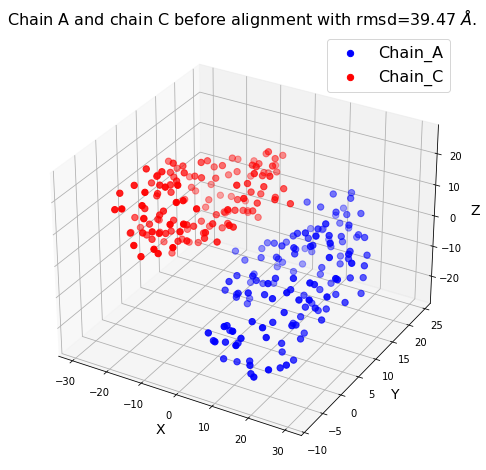

In [4]:
# plot the coordinates before alignment which reproduces Fig. (ii)
plot_atom_coordinates(coords1=ca_a, 
                      coords2=ca_c,
                      figsize=(8, 6),
                      label1="Chain_A",
                      label2="Chain_C",
                      title="Chain A and chain C before alignment with rmsd={:0.2f} $\AA$.".format(rmsd_before))

Now, we use rotational Procrustes to perform the structure alignment.

In [5]:
result = rotational(ca_a, ca_c, translate=True)

In [6]:
# compute transformed (translated & rotated) coordinates of chain A
ca_at = np.dot(result.new_a, result.t)

In [7]:
# now new_A is the array after rotation
rmsd_after = np.sqrt(np.mean(np.sum((ca_at - result.new_b)**2, axis=1)))
print("RMSD of transformed coordinates:", rmsd_after)

RMSD of transformed coordinates: 0.23003870483785005


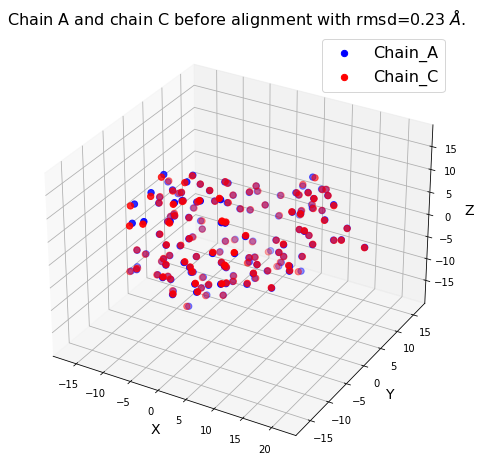

In [8]:
# plot the coordinates before alignment which reproduces Fig. (iii)
plot_atom_coordinates(coords1=ca_at, 
                      coords2=result["new_b"],
                      figsize=(8, 6),
                      label1="Chain_A",
                      label2="Chain_C",
                      title="Chain A and chain C before alignment with rmsd={:0.2f} $\AA$.".format(rmsd_after))

All the Cα atoms become close to each other after to
translation and rotation (the above figure) with rmsd value 0.23 $\unicode{x212B}$. This affirms that the utility of rotational Procrustes in protein alignment.